
## Project 3

### Team: Ahm Hamza



## Overview

This project develops a name-based gender classification system using the NLTK Names Corpus and a Random Forest classifier. The objective is to accurately predict the gender (male or female) of a given name by utilizing linguistic patterns and statistical techniques. The project begin with a baseline model using simple features (last letter of a name), and progressively design more expressive features such as: suffixes, prefixes, and phonetic characteristics, to improve classification performance. To assess model effectiveness, this project track accuracy across multiple feature sets and visualize results through confusion matrices and comparative bar plots.

## Here Is The Link Of My Video Presentation:
https://youtu.be/XrjeWjGSI0Q


In [ ]:
# all the necessary library
import nltk
from nltk.corpus import names
import random
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score


# Download required NLTK data
nltk.download('names')

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.


True

## Data Preparation and class balance

In this code cell, we first load the full list of male and female names from the NLTK Names Corpus and label each entry accordingly. To ensure that our training, development‑test, and test sets are representative and free from ordering bias, the study shuffle the male and female lists independently using a fixed random seed. We then construct three disjoint subsets: a 500‑name test set (250 male, 250 female), a 500‑name development‑test set (250 male, 250 female), and a training set containing the remaining names, balanced to the smaller class. Finally, we shuffle each subset once more to remove any residual ordering effects. The “evaluate_distribution” function prints the gender counts for each set, confirming that all subsets are exactly balanced with equal numbers of male and female names. This balanced split is crucial for fair model evaluation and prevents performance metrics from being skewed by class imbalance.

In [ ]:

def prepare_data():
    male_names = [(name, 'male') for name in names.words('male.txt')]
    female_names = [(name, 'female') for name in names.words('female.txt')]

    # shuffle each group individually
    random.seed(42)
    random.shuffle(male_names)
    random.shuffle(female_names)

    # create sets
    test_set = male_names[:250] + female_names[:250]
    dev_test_set = male_names[250:500] + female_names[250:500]

    # balance the training set
    min_count = min(len(male_names), len(female_names))
    train_set = male_names[500:min_count] + female_names[500:min_count]

    # final shuffle for each set to avoid order artifacts
    random.shuffle(test_set)
    random.shuffle(dev_test_set)
    random.shuffle(train_set)

    return train_set, dev_test_set, test_set

def evaluate_distribution(train_set, dev_test_set, test_set):
    print("Training set distribution:", Counter(gender for _, gender in train_set))
    print("Dev-test set distribution:", Counter(gender for _, gender in dev_test_set))
    print("Test set distribution:", Counter(gender for _, gender in test_set))


train_set, dev_test_set, test_set = prepare_data()
evaluate_distribution(train_set, dev_test_set, test_set)

Training set distribution: Counter({'female': 2443, 'male': 2443})
Dev-test set distribution: Counter({'female': 250, 'male': 250})
Test set distribution: Counter({'female': 250, 'male': 250})


**Features Extraction Functions**

Next cell functions defines a suite of feature‐extraction functions that transform each raw name string into a dictionary of attributes suitable for Random Forrest classifier can understand (numerical or categorical features).





 The code defines several feature functions, demonstrating an incremental approach to improving the features.  

* Basic_features: Extracts simple features like the last letter of the name and its length.
* Enhanced_suffix_features: Extracts suffixes of varying lengths (up to 3 		characters) and the name length. This helps capture common gender 		indicative endings.
* Prefix_features: Extracts prefixes of varying lengths.
phonetic_features Extracts features related to vowels, like the vowel count 	and the ratio of vowels to the total length.
* Comprehensive_features Combines features from all the previous 			functions to create a richer feature set.


In [ ]:
# features creation functions
def basic_features(name):
    # creates a feature set based on the last letter and length of the name
    return {'last_letter': name[-1].lower(), 'length': len(name)}

def enhanced_suffix_features(name):
    # generates features based on the length and last few characters (suffixes) of the name
    features = {'length': len(name)}
    for i in range(1, min(4, len(name) + 1)):
        features[f'suffix_{i}'] = name[-i:]
    return features

def prefix_features(name):
    # creates features based on the first few characters (prefixes) of the name
    return {f'prefix_{i}': name[:i] for i in range(1, min(4, len(name) + 1))}

def phonetic_features(name):
    # generates phonetic features by counting vowels and calculating the vowel ratio in the name
    vowels = 'aeiou'
    return {
        'vowel_count': sum(1 for c in name if c in vowels),
        'vowel_ratio': sum(1 for c in name if c in vowels) / len(name)
    }

def comprehensive_features(name):
    # combines features from all individual feature extraction functions into a single feature set
    f = {}
    f.update(basic_features(name))
    f.update(enhanced_suffix_features(name))
    f.update(prefix_features(name))
    f.update(phonetic_features(name))
    return f

## Model Training and Evaluation



This function “train_and_evaluate” that implements a more powerful ensemble classifier using a Random Forest. First, apply the provided `feature_extractor` to each name in both the training and development‑test sets, producing two parallel lists: “train_features” (a list of feature dictionaries) and “train_labels”(the corresponding gender labels), as well as `dev_features` and `dev_labels` for evaluation. Next, convert these dictionaries into numeric feature vectors using “DictVectorizer”, which learns a mapping from feature keys to columns and applies the same mapping to both training and development data. Then instantiate a “RandomForestClassifier” with 100 decision trees and a fixed random seed for reproducibility. The model is trained on the vectorized training data (`X_train`) and their labels. Finally, we predict genders for the development set (`X_dev`), compute the classification accuracy, and print it alongside the model name. By returning both the trained random‑forest model and the vectorizer,  preserve the exact feature‑to‑column mapping needed for later evaluation on the held‑out test set.


In [ ]:
def train_and_evaluate(train_set, dev_test_set, feature_extractor, model_name):
    # feature extraction
    train_features = [feature_extractor(name) for name, _ in train_set]
    train_labels = [gender for _, gender in train_set]

    dev_features = [feature_extractor(name) for name, _ in dev_test_set]
    dev_labels = [gender for _, gender in dev_test_set]

    # vectorization of features
    vec = DictVectorizer(sparse=False)
    X_train = vec.fit_transform(train_features)
    X_dev = vec.transform(dev_features)

    # train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, train_labels)

    # evaluate
    y_pred = rf.predict(X_dev)
    accuracy = accuracy_score(dev_labels, y_pred)
    print(f"{model_name} Dev-test accuracy: {accuracy:.4f}")

    return (rf, vec), accuracy  # return model and vectorizer


## Main Execution Pipeline

The main function acts as the execution pipeline for training and evaluating multiple Random Forest classifiers for gender classification based on names. It starts by calling prepare_data() to load and split the names corpus into balanced training, dev-test, and test sets. Two dictionaries are initialized: one for storing trained classifiers and another for recording their accuracy on the dev-test set.

Five feature extraction strategies are tested sequentially:

* A simple baseline using the last letter and length.
* An enhanced model with multiple-character suffixes.
* A prefix model.
* A phonetic model focused on vowel counts.
* A comprehensive model combining all features.



Each classifier is trained using the train_and_evaluate() function, which fits the model on the training set and computes accuracy on the dev-test set. The results are stored for comparison.

In [ ]:
def main():
    train_set, dev_test_set, test_set = prepare_data()
    models = {}
    accuracies = {}

    models['baseline'], accuracies['baseline'] = train_and_evaluate(
        train_set, dev_test_set, basic_features, "Baseline Model"
    )

    models['enhanced_suffix'], accuracies['enhanced_suffix'] = train_and_evaluate(
        train_set, dev_test_set, enhanced_suffix_features, "Enhanced Suffix Model"
    )

    models['prefix'], accuracies['prefix'] = train_and_evaluate(
        train_set, dev_test_set, prefix_features, "Prefix Model"
    )

    models['phonetic'], accuracies['phonetic'] = train_and_evaluate(
        train_set, dev_test_set, phonetic_features, "Phonetic Model"
    )

    models['comprehensive'], accuracies['comprehensive'] = train_and_evaluate(
        train_set, dev_test_set, comprehensive_features, "Comprehensive Model"
    )

    return models, accuracies, train_set, dev_test_set, test_set


## Visualizations

Visualization the dataset characteristics:

* A bar plot showing the overall gender distribution.
* A histogram illustrating the distribution of name lengths.
* A bar plot displaying the top 20 most frequent last letters in a sample of names.

/tmp/ipython-input-7-2758987845.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(gender_counts.keys()), y=list(gender_counts.values()), palette="pastel")


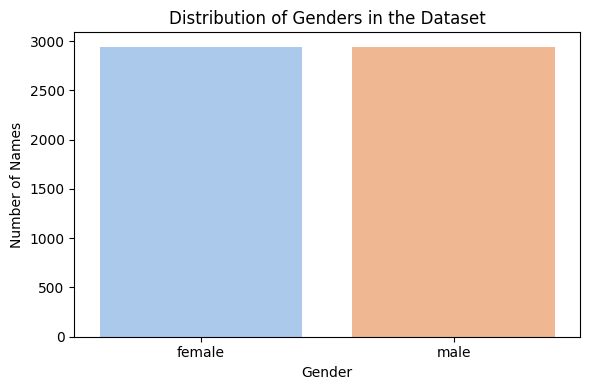

In [ ]:
# visualize the distribution of genders in the dataset
gender_counts = Counter(gender for _, gender in train_set + dev_test_set + test_set)

plt.figure(figsize=(6, 4))
sns.barplot(x=list(gender_counts.keys()), y=list(gender_counts.values()), palette="pastel")
plt.title("Distribution of Genders in the Dataset")
plt.ylabel("Number of Names")
plt.xlabel("Gender")
plt.tight_layout()
plt.show()

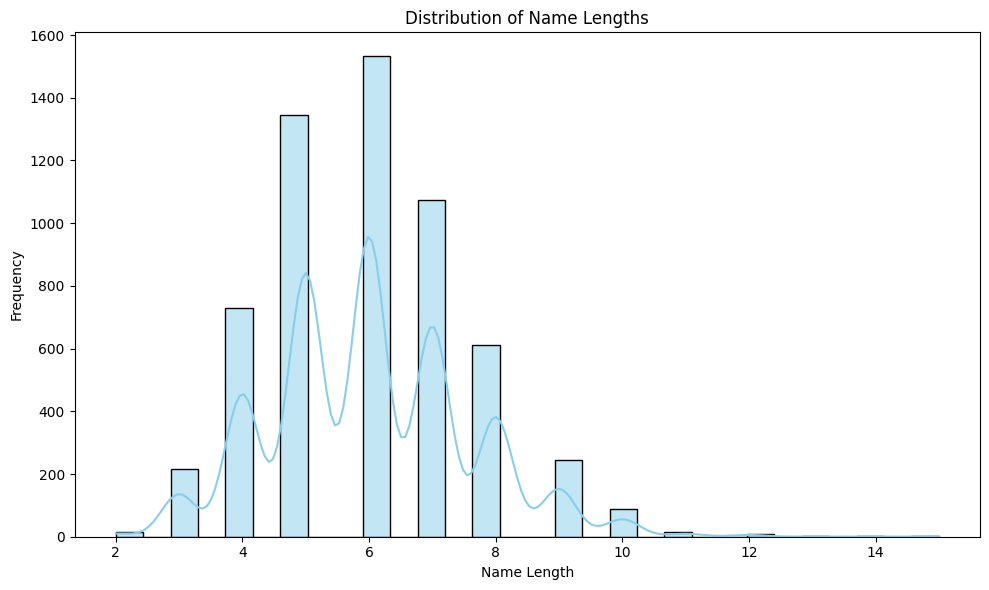

In [ ]:
# visualize the distribution of name lengths
all_names_flat = [name for name, _ in train_set + dev_test_set + test_set]
name_lengths = [len(name) for name in all_names_flat]

plt.figure(figsize=(10, 6))
sns.histplot(name_lengths, bins=30, kde=True, color='skyblue')
plt.title("Distribution of Name Lengths")
plt.xlabel("Name Length")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

/tmp/ipython-input-9-3183300494.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(last_letters), y=list(counts), palette="viridis")


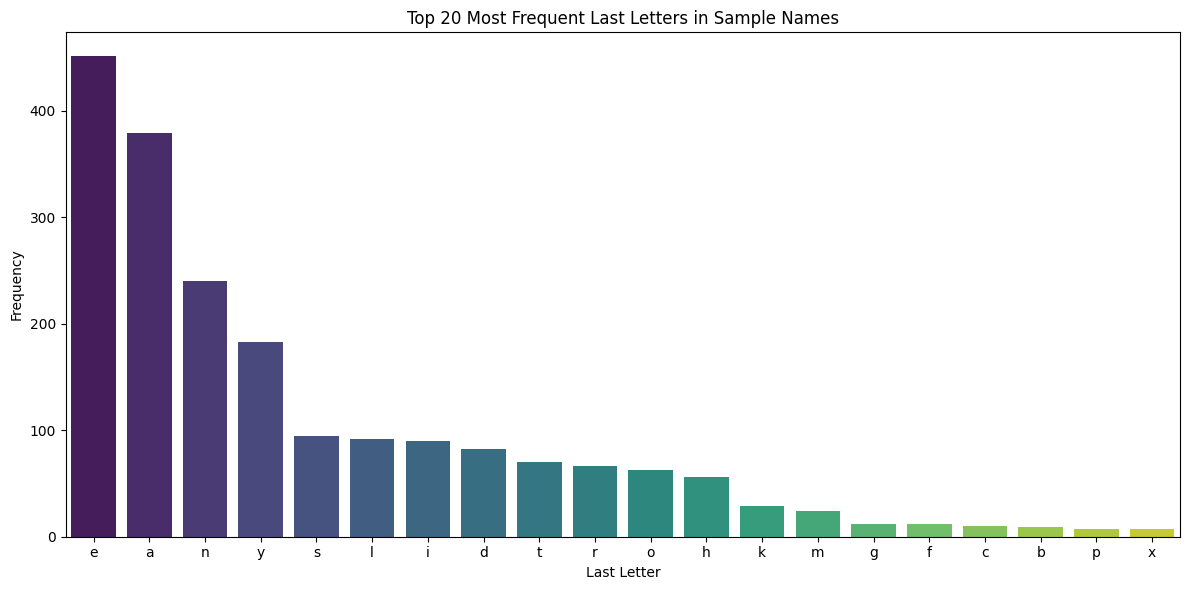

In [ ]:

# visualize the distribution of the last letter for a sample of names top 20 last letters

sample_names = random.sample(all_names_flat, min(2000, len(all_names_flat)))
last_letters = [name[-1].lower() for name in sample_names]
last_letter_counts = Counter(last_letters).most_common(20)
last_letters, counts = zip(*last_letter_counts)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(last_letters), y=list(counts), palette="viridis")
plt.title("Top 20 Most Frequent Last Letters in Sample Names")
plt.xlabel("Last Letter")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## Final Evaluation & models comparison visualization

"evaluate_on_test": This function accepts a trained model and vectorizer tuple (model_tuple), a test dataset (test_set), and a feature extractor function (feature_extractor). It extracts features from the test names, applies the vectorizer transformation, and uses the model to predict gender labels. The function then computes and returns the predicted labels (y_pred) and true labels (y_true) along with printing the test set accuracy.

The script evaluates the performance of the comprehensive model on the held-out test set, using the evaluate_on_test function. The predictions and true labels are used to construct a confusion matrix using sklearn.metrics.Confusion Matrix Display. This matrix visually shows the number of correct and incorrect predictions across the "male" and "female" classes, allowing inspection of misclassification patterns.

Accuracy Comparison Bar Plot:
To compare the predictive performance of all feature-based models (Baseline, Enhanced Suffix, Prefix, Phonetic, and Comprehensive), a bar plot is generated using seaborn. The accuracies collected during dev-test evaluation are plotted for each model. This visualization highlights which feature sets are most effective for the task and helps diagnose which models underperform or generalize better.

Baseline Model Dev-test accuracy: 0.7680
Enhanced Suffix Model Dev-test accuracy: 0.7960
Prefix Model Dev-test accuracy: 0.6960
Phonetic Model Dev-test accuracy: 0.6340
Comprehensive Model Dev-test accuracy: 0.8020
Test accuracy: 0.7680


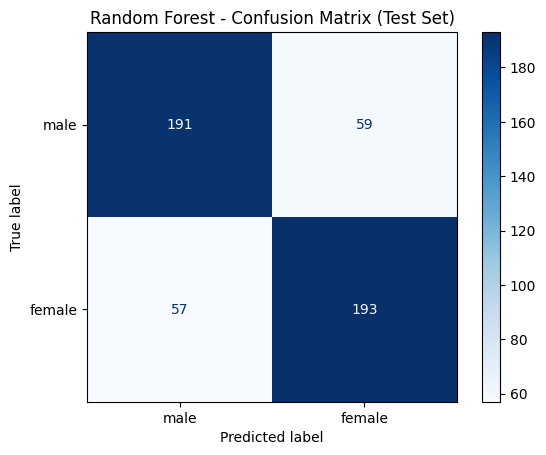

/tmp/ipython-input-19-63686120.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(comparison_accuracies.keys()), y=list(comparison_accuracies.values()), palette="coolwarm")


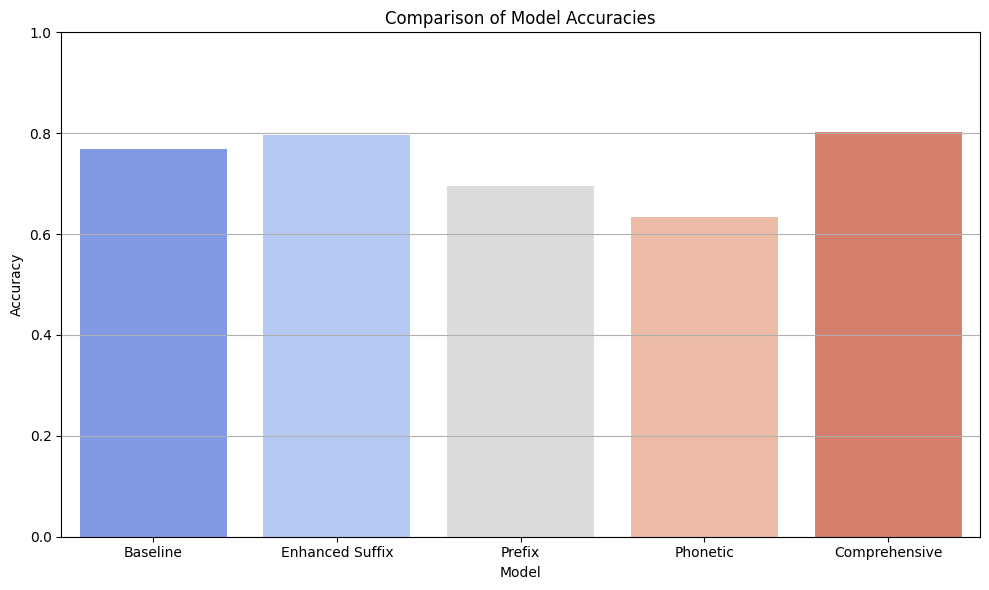

In [ ]:


def evaluate_on_test(model_tuple, test_set, feature_extractor):
    model, vec = model_tuple
    test_features = [feature_extractor(name) for name, _ in test_set]
    test_labels = [gender for _, gender in test_set]
    X_test = vec.transform(test_features)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(test_labels, y_pred)
    print(f"Test accuracy: {accuracy:.4f}")

    return y_pred, test_labels

if __name__ == "__main__":
    models, accuracies, train_set, dev_test_set, test_set = main()

    # Evaluate comprehensive model on test set
    y_pred, y_true = evaluate_on_test(models['comprehensive'], test_set, comprehensive_features)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=["male", "female"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["male", "female"])
    disp.plot(cmap="Blues")
    plt.title("Random Forest - Confusion Matrix (Test Set)")
    plt.show()

    # Prepare accuracies for comparison
    comparison_accuracies = {
        'Baseline': accuracies['baseline'],
        'Enhanced Suffix': accuracies['enhanced_suffix'],
        'Prefix': accuracies['prefix'],
        'Phonetic': accuracies['phonetic'],
        'Comprehensive': accuracies['comprehensive']
    }

    # Visualization of model accuracies
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(comparison_accuracies.keys()), y=list(comparison_accuracies.values()), palette="coolwarm")
    plt.title("Comparison of Model Accuracies")
    plt.ylabel("Accuracy")
    plt.ylim(0.0, 1.0)
    plt.xlabel("Model")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

## Result
The performance of the Random Forest–based gender classifier varied across the different feature and  configurations, with the Comprehensive Model achieving the highest dev‑test accuracy of 0.8020, followed closely by the Enhanced Suffix Model at 0.7960, and the Baseline Model at 0.7680. The Prefix Model and Phonetic Model performed less well on the dev‑test set, with accuracies of 0.6960 and 0.6340, respectively. When the final Comprehensive Model was evaluated on the independent test set, it achieved an accuracy of 0.7680, which is 3.4 percentage points lower than its dev‑test accuracy yet still superior to several of the simpler feature sets.

This slightly lower accuracy on the test set compared to the dev‑test set is  expected in a well‑controlled experimental design. The dev‑test set is used repeatedly during model development for feature selection and hyperparameter tuning, so the model can become subtly tailored to its particular examples. In contrast, the test set remains untouched until the final evaluation, and as such it provides a more honest estimate of generalization performance. A modest drop from 0.8020 to 0.7680 suggests that our comprehensive set of features captured robust gender‑discriminative patterns without excessive overfitting. The fact that the test‑set accuracy remains considerably above the simplest baseline underscores the value of our suffix‑ and combined feature engineering. Overall, the results demonstrate that the Random Forest classifier generalizes well, with the expected minor decrease in accuracy when moving from development to held‑out data.